In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# !pip install fuzzywuzzy
# !pip install scikit-surprise

In [3]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV


In [4]:
from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [5]:
movies = pd.read_csv('movies.csv')
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [6]:
movies['newId'] = range(1, movies['movieId'].nunique() + 1)

In [7]:
movies.head(3)

,movieId,title,genres,newId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,2
2,3,Grumpier Old Men (1995),Comedy|Romance,3


In [8]:
movie_ratings = pd.read_csv('ratings.csv')
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [9]:
movie_ratings['timestamp'] = movie_ratings['timestamp'].apply(lambda x : datetime.utcfromtimestamp(x).strftime("%Y-%m-%d"))

In [10]:
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02
1,1,29,3.5,2005-04-02
2,1,32,3.5,2005-04-02
3,1,47,3.5,2005-04-02
4,1,50,3.5,2005-04-02


In [11]:
movie_ratings = movie_ratings.merge(movies, how = "left", on = "movieId")

In [12]:
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres,newId
0,1,2,3.5,2005-04-02,Jumanji (1995),Adventure|Children|Fantasy,2
1,1,29,3.5,2005-04-02,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,29
2,1,32,3.5,2005-04-02,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,32
3,1,47,3.5,2005-04-02,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,47
4,1,50,3.5,2005-04-02,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,50


In [13]:
movie_ratings.rename(columns = {"timestamp" : "date"}, inplace=True)

In [14]:
movie_ratings["movieId"] = movie_ratings['newId']
movies['movieId'] = movies['newId']

In [15]:
movie_ratings.drop(['newId'],axis=1, inplace=True)
movies.drop(['newId'], axis=1, inplace=True)

In [16]:
movie_ratings.sort_values(by="date", inplace=True)
movie_ratings.reset_index(drop=True, inplace=True)
# movies.sort_values(by="date", inplace=True)

In [17]:
print(movie_ratings.shape)
print(movie_ratings.columns)

(20000263, 6)
Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


Data Cleaning


In [18]:
movie_ratings.duplicated().sum()

0

No duplicates found

In [19]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   date     object 
 4   title    object 
 5   genres   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


In [20]:
movie_ratings.isna().sum()

userId     0
movieId    0
rating     0
date       0
title      0
genres     0
dtype: int64

## EDA

#### Univariate Analysis

In [21]:
movie_ratings.head(2)

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller


In [22]:
total_users = movie_ratings['userId'].nunique()
print(total_users)

138493


In [23]:
# Top 5 user id's 
movie_ratings['userId'].value_counts()[:5]

userId
118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
Name: count, dtype: int64

userId 118205 has around 9K records in the dataset.

In [24]:
# movieID
total_movies = movie_ratings['movieId'].nunique()
print("Total number of movies in dataset: ",total_movies)
print(f"Top 5 movies in dataset are: {movie_ratings['movieId'].value_counts()[:5]}")

Total number of movies in dataset:  26744
Top 5 movies in dataset are: movieId
294    67310
353    66172
316    63366
588    63299
477    59715
Name: count, dtype: int64


In [25]:
# To bring numerical values in Millions 
def changing_labels(number):
    return str(number/10**6) + "M"

Rating column

<Axes: xlabel='rating', ylabel='count'>

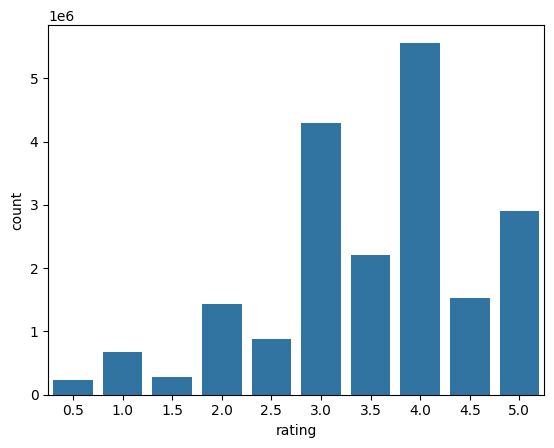

In [26]:
sns.countplot(x = "rating", data = movie_ratings)

<Axes: xlabel='rating'>

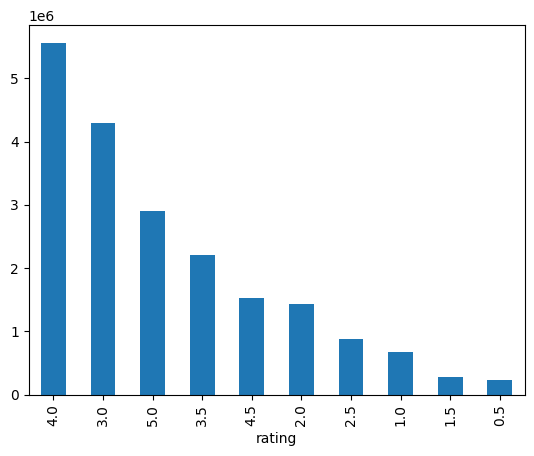

In [27]:
movie_ratings['rating'].value_counts().plot(kind='bar')

date column

In [28]:
print(f"Count of unique dates: {movie_ratings['date'].nunique()}")
print(f"First rating date: {movie_ratings['date'].min()}")
print(f"Last rating date: {movie_ratings['date'].max()}")
print(f"5 most common dates when ratings were given: {movie_ratings['date'].value_counts()[:5]}")

Count of unique dates: 6911
First rating date: 1995-01-09
Last rating date: 2015-03-31
5 most common dates when ratings were given: date
2000-11-20    91753
2005-03-22    76568
1999-12-11    65077
2008-10-29    55163
2000-11-21    54131
Name: count, dtype: int64


In [29]:
movie_list = movie_ratings["title"].unique()
print("The count of unique title in the dataset is : ", movie_ratings["title"].nunique())
print("The top 5 title in the dataset are : \n", movie_ratings["title"].value_counts()[:5])

The count of unique title in the dataset is :  26729
The top 5 title in the dataset are : 
 title
Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: count, dtype: int64


In [30]:
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


In [31]:
movie_ratings['genres']

0                       Comedy|Crime
1                   Mystery|Thriller
2              Drama|Fantasy|Romance
3              Comedy|Crime|Thriller
4                     Comedy|Romance
                      ...           
20000258              Action|Western
20000259    Adventure|Comedy|Musical
20000260                Comedy|Drama
20000261                 Documentary
20000262             Musical|Romance
Name: genres, Length: 20000263, dtype: object

In [32]:
unique_genres = {}
def extractGenres(x):
    for g in x.split("|"):
        if g not in unique_genres.keys():
            unique_genres[g]=1
        else:
            unique_genres[g] += 1
movie_ratings['genres'].apply(extractGenres)
print("Genres extracted from the text")

Genres extracted from the text


In [33]:
movie_ratings.head(2)

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller


In [34]:
unique_genres

{'Comedy': 7502234,
 'Crime': 3298335,
 'Mystery': 1557282,
 'Thriller': 5313506,
 'Drama': 8857853,
 'Fantasy': 2111403,
 'Romance': 3802002,
 'Action': 5614208,
 'Adventure': 4380351,
 'Animation': 1140476,
 'Children': 1669249,
 'Sci-Fi': 3150141,
 'Horror': 1482737,
 'Musical': 870915,
 'War': 1048618,
 'Documentary': 244619,
 'Western': 423714,
 'Film-Noir': 216689,
 'IMAX': 492366,
 '(no genres listed)': 361}

In [35]:
genres_df = pd.DataFrame(list(unique_genres.items()))
genres_df.columns=["Genre", "Count"]
genres_df

,Genre,Count
0,Comedy,7502234
1,Crime,3298335
2,Mystery,1557282
3,Thriller,5313506
4,Drama,8857853
5,Fantasy,2111403
6,Romance,3802002
7,Action,5614208
8,Adventure,4380351
9,Animation,1140476


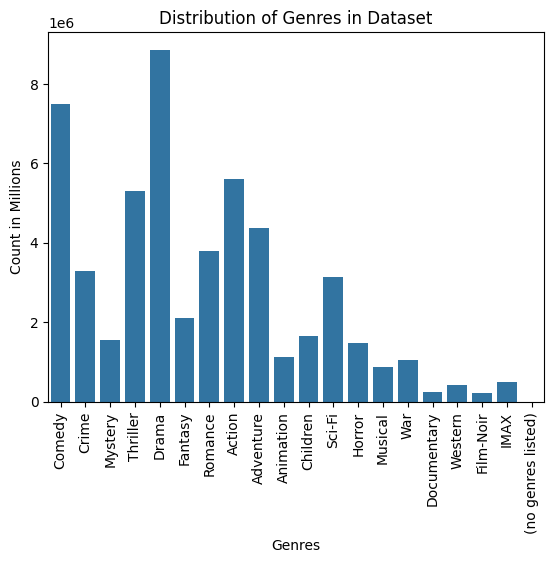

In [36]:
sns.barplot(x='Genre', y='Count', data=genres_df)
plt.title("Distribution of Genres in Dataset")
plt.xlabel("Genres")
plt.ylabel("Count in Millions")
plt.xticks(rotation = 90)
plt.show()

In [37]:
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


In [38]:
from sklearn.model_selection import train_test_split

In [39]:
Train_data, Test_data = train_test_split(movie_ratings, test_size=0.2, shuffle = False)

In [40]:
Train_Data = Train_data

In [41]:
Train_data.to_pickle("Train_data.pkl")

In [42]:
Test_Data = Test_data

In [43]:
# Create list of unique movies 

movie_list_in_training = Train_Data.drop_duplicates(subset = ['title'], keep = 'first')[['movieId', 'title', 'genres']]
movie_list_in_training = movie_list_in_training.reset_index(drop=True)
movie_list_in_training.head()

,movieId,title,genres
0,1058,"Fish Called Wanda, A (1988)",Comedy|Crime
1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,1154,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,21,Get Shorty (1995),Comedy|Crime|Thriller
4,7,Sabrina (1995),Comedy|Romance


In [44]:
# Checking the basic statistics for the training data

print("Total Train Data..")
print("Total number of movie ratings in train data : ", str(Train_Data.shape[0]))
print("Number of unique users in train data : ", str(len(np.unique(Train_Data["userId"]))))
print("Number of unique movies in train data : ", str(len(np.unique(Train_Data["movieId"]))))

Total Train Data..
Total number of movie ratings in train data :  16000210
Number of unique users in train data :  112466
Number of unique movies in train data :  12387


Bi variate Analysis

In [45]:
Train_data['rating'].describe()

count    1.600021e+07
mean     3.512613e+00
std      1.059931e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [46]:
Train_Data.head()

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


<Axes: xlabel='rating'>

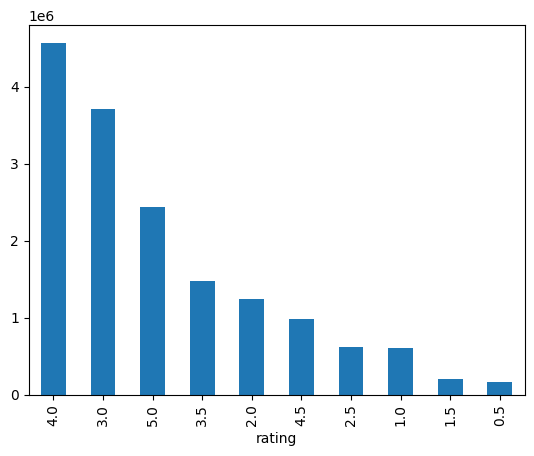

In [47]:
ax = Train_Data.rating.value_counts().plot(kind = 'bar')
ax

In [48]:
Train_Data.head(2)

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller


In [ ]:
Train_Data['date'] = pd.to_datetime(Train_Data['date'], errors = 'coerce')
Train_Data["DayOfWeek"] = Train_Data["date"].dt.strftime("%A")
Train_Data["WeekDay"] = Train_Data['date'].apply(lambda x: 1 if x.dayofweek > 5 else 0)

In [ ]:
Train_Data.head()

,userId,movieId,rating,date,title,genres,DayOfWeek,WeekDay
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime,Monday,0
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Monday,0
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance,Monday,0
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller,Monday,0
4,85252,12,1.0,1996-01-29,Dracula: Dead and Loving It (1995),Comedy|Horror,Monday,0


In [ ]:
Train_Data[Train_Data["DayOfWeek"] == "Saturday"].head()

,userId,movieId,rating,date,title,genres,DayOfWeek,WeekDay
220,124035,101,3.0,1996-02-10,Mr. Wrong (1996),Comedy,Saturday,0
261,8050,110,5.0,1996-02-17,Taxi Driver (1976),Crime|Drama|Thriller,Saturday,0
262,8050,109,4.0,1996-02-17,Braveheart (1995),Action|Drama|War,Saturday,0
1156,76615,185,4.0,1996-03-02,Nine Months (1995),Comedy|Romance,Saturday,0
1157,92320,192,4.0,1996-03-02,Showgirls (1995),Drama,Saturday,0


In [ ]:
# Changing labels in 100's (K's)

def ChangingLabelsinK(number):
    return str(int((number/10**3))) + "K"

C:\Users\ASUS\AppData\Local\Temp\ipykernel_28372\588623561.py:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  Train_Data.resample("m", on="date")["rating"].count().plot()


<Axes: xlabel='date'>

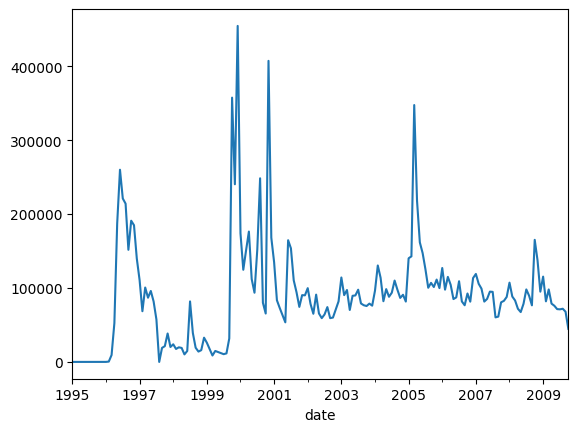

In [ ]:
Train_Data.resample("m", on="date")["rating"].count().plot()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_28372\4091951025.py:3: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  axes = Train_Data.resample("m", on = "date")["rating"].count().plot()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_28372\4091951025.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels([ChangingLabelsinK(num) for num in axes.get_yticks()])


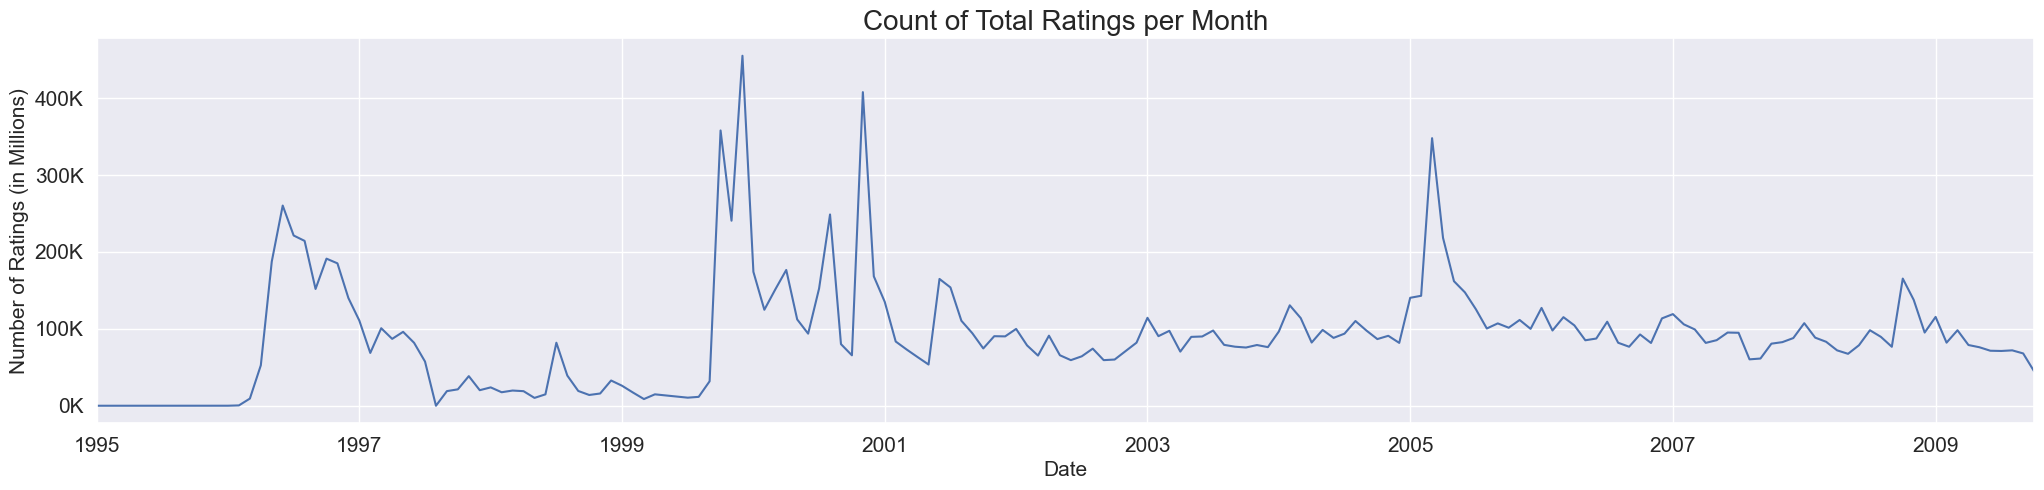

In [ ]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
axes = Train_Data.resample("m", on = "date")["rating"].count().plot()

axes.set_yticklabels([ChangingLabelsinK(num) for num in axes.get_yticks()])
axes.set_title("Count of Total Ratings per Month", fontsize = 20)
axes.set_xlabel("Date", fontsize = 15)
axes.set_ylabel("Number of Ratings (in Millions)", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.show()

<Axes: xlabel='WeekDay'>

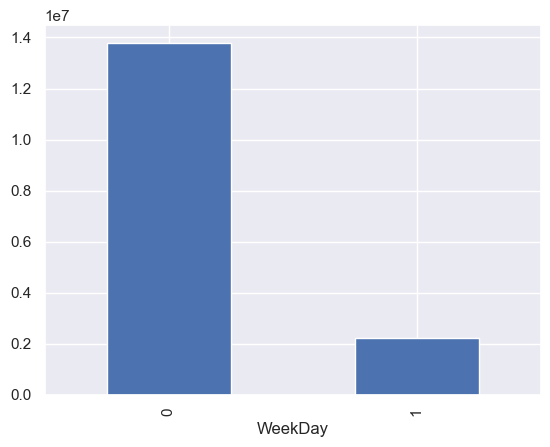

In [ ]:
Train_Data.WeekDay.value_counts().plot(kind = "bar")

In [ ]:
Train_Data.head(2)

,userId,movieId,rating,date,title,genres,DayOfWeek,WeekDay
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime,Monday,0
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Monday,0


<Axes: xlabel='DayOfWeek'>

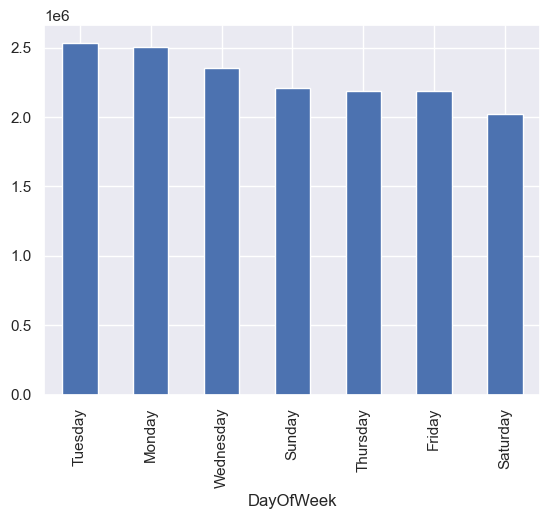

In [ ]:
Train_Data['DayOfWeek'].value_counts().plot(kind = "bar")

Analyzing the average ratings by date

<Axes: xlabel='WeekDay', ylabel='rating'>

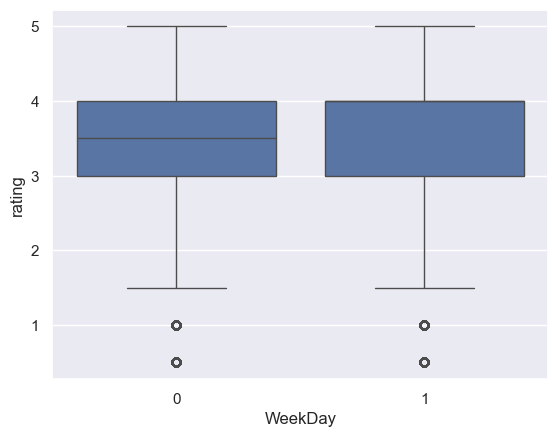

In [ ]:
sns.boxplot(x = "WeekDay", y = "rating", data = Train_Data)

<Axes: xlabel='DayOfWeek', ylabel='rating'>

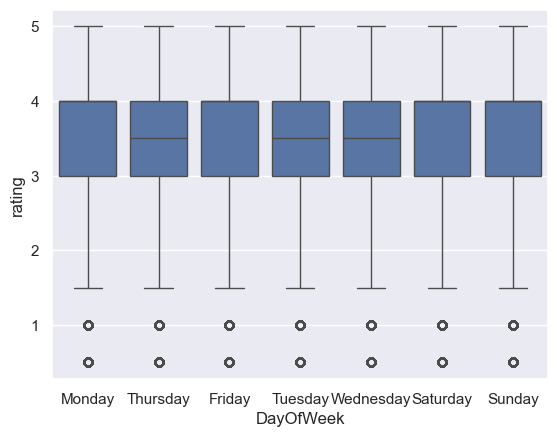

In [ ]:
sns.boxplot(x="DayOfWeek", y="rating", data=Train_Data)

In [ ]:
Train_Data.groupby(by=["userId"])["rating"].count().reset_index().sort_values(by="rating", ascending = False)

,userId,rating
95989,118205,7677
6876,8405,7168
67374,83090,5169
66813,82418,4739
102177,125794,4652
...,...,...
87625,107926,1
36772,45443,1
53415,66004,1
24905,30778,1


In [ ]:
# Analyzing ratings given by user 

no_of_rated_movies_per_user = Train_Data.groupby(by=["userId"], as_index=False)["rating"].count().sort_values(by="rating", ascending=False)
no_of_rated_movies_per_user.reset_index(drop=True, inplace=True)

In [ ]:
no_of_rated_movies_per_user

,userId,rating
0,118205,7677
1,8405,7168
2,83090,5169
3,82418,4739
4,125794,4652
...,...,...
112465,107926,1
112466,45443,1
112467,66004,1
112468,30778,1


<Axes: xlabel='userId', ylabel='rating'>

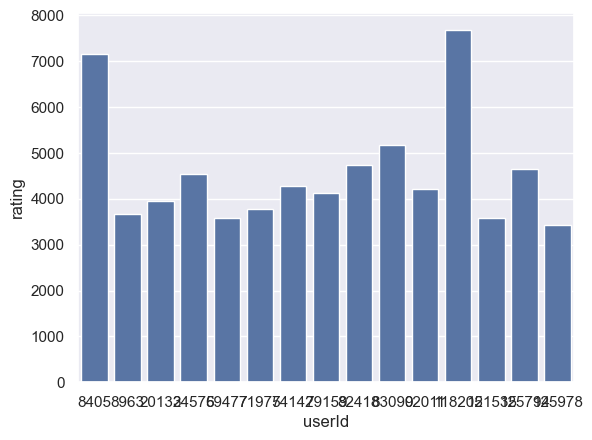

In [ ]:
sns.barplot(x = "userId", y="rating", data = no_of_rated_movies_per_user[:15])

PDF

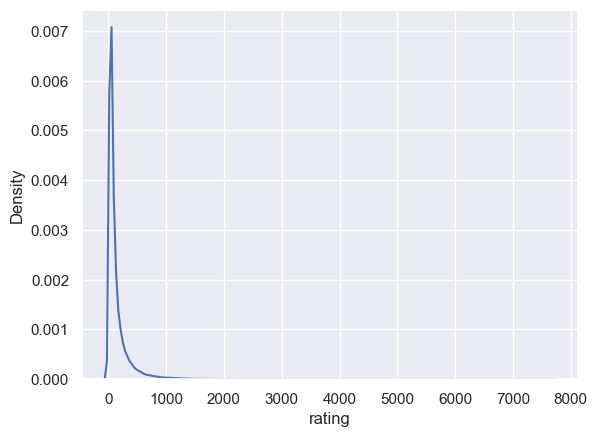

In [ ]:
sns.kdeplot(no_of_rated_movies_per_user['rating'])
plt.show()

CDF

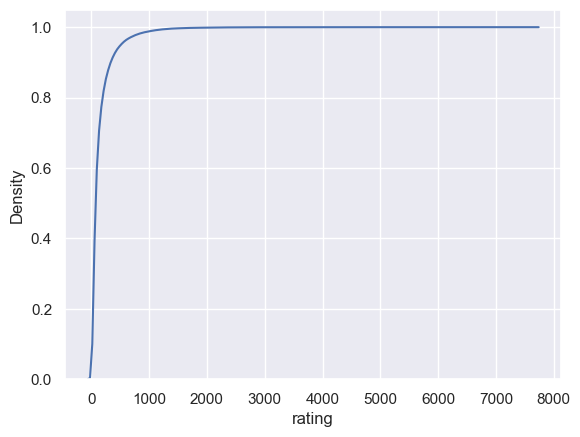

In [ ]:
sns.kdeplot(no_of_rated_movies_per_user['rating'], cumulative=True)
plt.show()

In [ ]:
no_of_rated_movies_per_user["rating"].describe()

count    112470.000000
mean        142.262025
std         214.804550
min           1.000000
25%          35.000000
50%          69.000000
75%         155.000000
max        7677.000000
Name: rating, dtype: float64

In [ ]:
quantiles = no_of_rated_movies_per_user["rating"].quantile(np.arange(0.9, 1.01, 0.01))
qvalue = np.arange(0.9, 1.01, 0.01)

for cnt in qvalue:
    print(f"The {int(cnt*100)} % value is {quantiles[cnt]}")

The 90 % value is 333.0
The 91 % value is 358.0
The 92 % value is 386.0
The 93 % value is 418.0
The 94 % value is 459.0
The 95 % value is 510.0
The 96 % value is 573.0
The 97 % value is 664.0
The 98 % value is 804.6200000000099
The 99 % value is 1060.3100000000122
The 100 % value is 7677.0


In [ ]:
no_of_ratings_per_movie = Train_Data.groupby(["movieId", "title"])["rating"].count().reset_index().sort_values(by="rating", ascending=False)

In [ ]:
no_of_ratings_per_movie

,movieId,title,rating
293,294,Pulp Fiction (1994),55434
352,353,Forrest Gump (1994),54873
587,588,"Silence of the Lambs, The (1991)",53206
476,477,Jurassic Park (1993),51905
315,316,"Shawshank Redemption, The (1994)",49596
...,...,...,...
11698,13519,Playing for Keeps (1986),1
11687,13508,"Hell of a Day, A (Reines d'un jour) (2001)",1
12204,14105,Paris (2007),1
12205,14106,"Secret of Moonacre, The (2008)",1


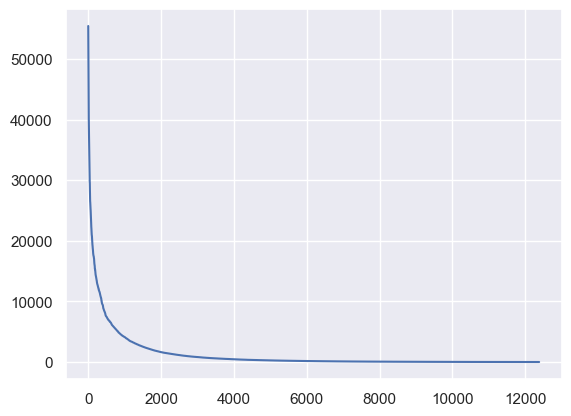

In [ ]:
plt.plot(no_of_ratings_per_movie["rating"].values)

In [ ]:
no_of_ratings_per_movie

,movieId,title,rating
293,294,Pulp Fiction (1994),55434
352,353,Forrest Gump (1994),54873
587,588,"Silence of the Lambs, The (1991)",53206
476,477,Jurassic Park (1993),51905
315,316,"Shawshank Redemption, The (1994)",49596
...,...,...,...
11698,13519,Playing for Keeps (1986),1
11687,13508,"Hell of a Day, A (Reines d'un jour) (2001)",1
12204,14105,Paris (2007),1
12205,14106,"Secret of Moonacre, The (2008)",1


In [ ]:
sns.barplot(x = "title", y="rating", data = no_of_ratings_per_movie[:15])

KeyboardInterrupt: 